In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Reproducibility
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [3]:
import pickle

# Load the arrays from the pickle file
with open('/kaggle/input/1125s-heart-sound-data-tvt-split-acc-985/split_98_5.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['x_train']
x_test = data['x_test']
x_val = data['x_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

In [4]:
x_train.shape

(640, 1125)

In [5]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model

class_names = list(['Aortic Stenosis','Mitral Regurgitation','Mitral Stenosis','Mitral Valve Prolapse', 'Normal'])

# Define the input shape
dim = x_train[0].shape
input_shape = (dim[0], 1)

# Define the input tensor
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv1D(64, 7, strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
# Residual Block
residue = x


filters = 64
kernel_size = 3
steps = 1
# ResNet 34 Layers
block_repeats = (3, 4, 6, 3)

# Generalized Loop for Repetative Blocks
for i in block_repeats:
    for j in range(i):
        x = Conv1D(filters, kernel_size, strides=steps, padding='same', activation='relu')(x)
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = Add()([x, residue])
        x = Activation('relu')(x)
        residue = x
        steps=1
        
    filters=filters*2
    steps=2
    residue = Conv1D(filters, 1, strides=steps, padding='same', activation='relu')(x)

# Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer fully connected
outputs = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1125, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 563, 64)      512         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 282, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 282, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                              

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss for learning rate reduction
    factor=0.6,            # Reduce learning rate by a factor
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Minimum learning rate
)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 100
batch_size = 100
history = model.fit(x_train, y_train, 
                    validation_data=(x_val,y_val),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback,checkpoint_callback,early_stopping_callback],
                    shuffle=True
                   )

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/100
7/7 [==============================] - 22s 380ms/step - loss: 1.6954 - accuracy: 0.2078 - val_loss: 1.6091 - val_accuracy: 0.2250 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 1s 131ms/step - loss: 1.6077 - accuracy: 0.2266 - val_loss: 1.6065 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 0s 67ms/step - loss: 1.5804 - accuracy: 0.2594 - val_loss: 1.6104 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 0s 66ms/step - loss: 1.6079 - accuracy: 0.2250 - val_loss: 1.6076 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 1s 127ms/step - loss: 1.5790 - accuracy: 0.2469 - val_loss: 1.5730 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 1s 134ms/step - loss: 1.5317 - accuracy: 0.3547 - val_loss: 1.5231 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 1s 130ms/step - loss: 1.50

In [7]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted probabilities for the test data
# Make predictions
predictions = best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

7/7 [==============================] - 1s 9ms/step
Classification Report:
                        precision    recall  f1-score   support

      Aortic Stenosis       1.00      0.98      0.99        41
 Mitral Regurgitation       0.98      0.95      0.97        44
      Mitral Stenosis       0.91      0.88      0.90        34
Mitral Valve Prolapse       0.93      0.97      0.95        38
               Normal       0.98      1.00      0.99        43

             accuracy                           0.96       200
            macro avg       0.96      0.96      0.96       200
         weighted avg       0.96      0.96      0.96       200



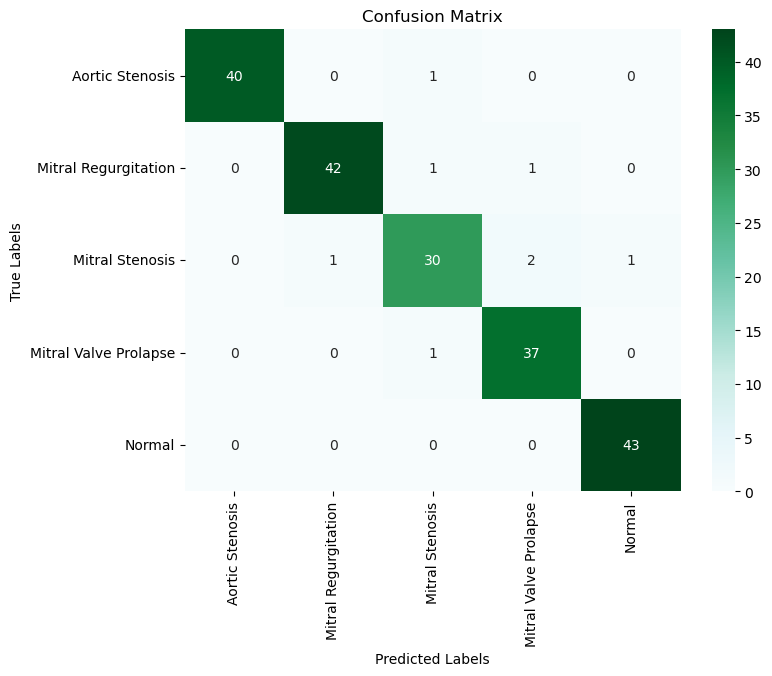

In [8]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

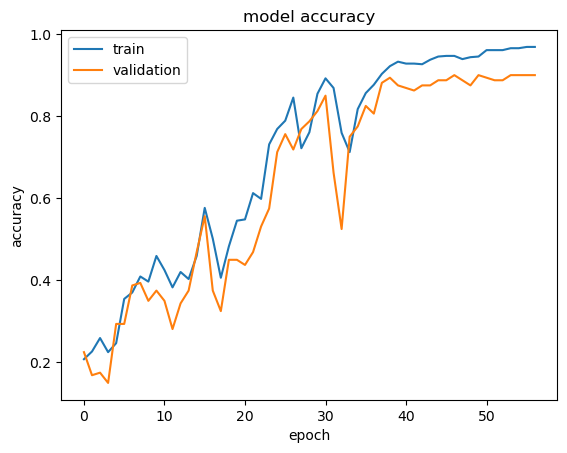

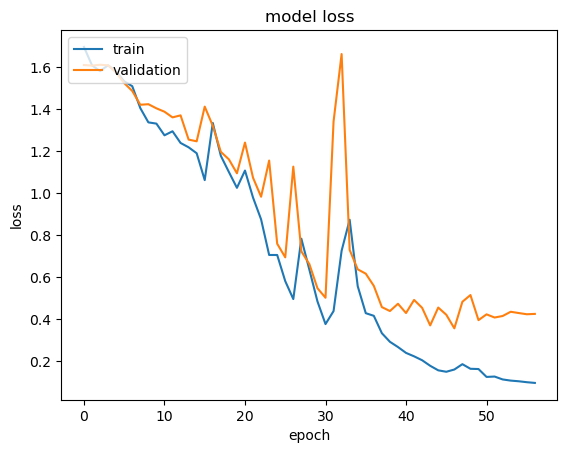

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()